In [1]:
import json
import multiprocessing
import os
import random
import string
import time

import cv2
import matplotlib.pyplot as plt
from mxboard import SummaryWriter
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon.model_zoo.vision import resnet34_v1
import numpy as np
from skimage import transform as skimage_tf
from skimage import exposure
from tqdm import tqdm
np.seterr(all='raise')
plt.rcParams['figure.figsize'] = [5, 5]
mx.random.seed(1)

from ocr.utils.iam_dataset import IAMDataset, resize_image
from ocr.utils.draw_text_on_image import draw_text_on_image

alphabet_encoding = r' $!"#&\'()~^<>[]|_{}=@%*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
alphabet_dict = {alphabet_encoding[i]:i for i in range(len(alphabet_encoding))}

In [2]:
class EncoderLayer(gluon.HybridBlock):
    '''The encoder layer takes the image features from a CNN. The image features are transposed so that the LSTM 
    slices of the image features can be sequentially fed into the LSTM from left to right (and back via the
    bidirectional LSTM). 
    '''
    def __init__(self, hidden_states=200, rnn_layers=1, max_seq_len=100, **kwargs):
        self.max_seq_len = max_seq_len
        super(EncoderLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.lstm = mx.gluon.rnn.LSTM(hidden_states, rnn_layers, bidirectional=True)

    def hybrid_forward(self, F, x):
        x = x.transpose((0, 3, 1, 2))
        x = x.flatten()
        x = x.split(num_outputs=self.max_seq_len, axis=1) # (SEQ_LEN, N, CHANNELS)
        x = F.concat(*[elem.expand_dims(axis=0) for elem in x], dim=0)
        x = self.lstm(x)
        x = x.transpose((1, 0, 2)) #(N, SEQ_LEN, HIDDEN_UNITS)
        return x

class CNNBiLSTM(gluon.HybridBlock):
    '''The CNN-biLSTM to recognise handwriting text given an image of handwriten text.
    Parameters
    ----------
    num_downsamples: int, default 2
        The number of times to downsample the image features. Each time the features are downsampled, a new LSTM
        is created. 
    resnet_layer_id: int, default 4
        The layer ID to obtain features from the resnet34
    lstm_hidden_states: int, default 200
        The number of hidden states used in the LSTMs
    lstm_layers: int, default 1
        The number of layers of LSTMs to use
    '''
    FEATURE_EXTRACTOR_FILTER = 64
    def __init__(self, num_downsamples=2, resnet_layer_id=4, rnn_hidden_states=200, rnn_layers=1, max_seq_len=100, ctx=mx.gpu(), **kwargs):
        super(CNNBiLSTM, self).__init__(**kwargs)
        self.p_dropout = 0.5
        self.num_downsamples = num_downsamples
        self.max_seq_len = max_seq_len
        self.ctx = ctx
        with self.name_scope():
            self.body = self.get_body(resnet_layer_id=resnet_layer_id)
            self.encoders = gluon.nn.HybridSequential()
            with self.encoders.name_scope():
                for i in range(self.num_downsamples):
                    encoder = self.get_encoder(rnn_hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len)
                    self.encoders.add(encoder)
            self.decoder = self.get_decoder()
            self.downsampler = self.get_down_sampler(self.FEATURE_EXTRACTOR_FILTER)

    def get_down_sampler(self, num_filters):
        '''Creates a two-stacked Conv-BatchNorm-Relu and then a pooling layer to
        downsample the image features by half.
 
        Parameters
        ----------
        num_filters: int
            To select the number of filters in used the downsampling convolutional layer.
        Returns
        -------
        network: gluon.nn.HybridSequential
            The downsampler network that decreases the width and height of the image features by half.
        
        '''
        out = gluon.nn.HybridSequential()
        with out.name_scope():
            for _ in range(2):
                out.add(gluon.nn.Conv2D(num_filters, 3, strides=1, padding=1))
                out.add(gluon.nn.BatchNorm(in_channels=num_filters))
                out.add(gluon.nn.Activation('relu'))
            out.add(gluon.nn.MaxPool2D(2))
            out.collect_params().initialize(mx.init.Normal(), ctx=self.ctx)
        out.hybridize()
        return out

    def get_body(self, resnet_layer_id):
        '''Create the feature extraction network based on resnet34.
        The first layer of the res-net is converted into grayscale by averaging the weights of the 3 channels
        of the original resnet.
        
        Parameters
        ----------
        resnet_layer_id: int
            The resnet_layer_id specifies which layer to take from 
            the bottom of the network.
        Returns
        -------
        network: gluon.nn.HybridSequential
            The body network for feature extraction based on resnet
        '''
        pretrained = resnet34_v1(pretrained=True, ctx=self.ctx)
        pretrained_2 = resnet34_v1(pretrained=True, ctx=mx.cpu(0))
        first_weights = pretrained_2.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        # First weights could be replaced with individual channels.
        
       	body = gluon.nn.HybridSequential()
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Xavier(), ctx=self.ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:-resnet_layer_id])
        return body

    def get_encoder(self, rnn_hidden_states, rnn_layers, max_seq_len):
        '''Creates an LSTM to learn the sequential component of the image features.
        
        Parameters
        ----------
        
        rnn_hidden_states: int
            The number of hidden states in the RNN
            
        rnn_layers: int
            The number of layers to stack the RNN
        Returns
        -------
        
        network: gluon.nn.Sequential
            The encoder network to learn the sequential information of the image features
        '''
        encoder = gluon.nn.HybridSequential()
        with encoder.name_scope():
            encoder.add(EncoderLayer(hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len))
            encoder.add(gluon.nn.Dropout(self.p_dropout))
        encoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return encoder
    
    def get_decoder(self):
        ''' Creates a network to convert the output of the encoder into characters.
        '''
        alphabet_size = len(alphabet_encoding) + 1
        decoder = mx.gluon.nn.Dense(units=alphabet_size, flatten=False)
        decoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return decoder

    def hybrid_forward(self, F, x):
        features = self.body(x)
        hidden_states = []
        hs = self.encoders[0](features)
        hidden_states.append(hs)
        for i, _ in enumerate(range(self.num_downsamples - 1)):
            features = self.downsampler(features)
            hs = self.encoders[i+1](features)
            hidden_states.append(hs)
        hs = F.concat(*hidden_states, dim=2)
        output = self.decoder(hs)
        return output

In [3]:
def transform(image, label):
    '''This function resizes the input image and converts so that it could be fed into the network.
    Furthermore, the label (text) is one-hot encoded.
    '''
    image = np.expand_dims(image, axis=0).astype(np.float32)
    #print(image[0,0,0])
    if image[0, 0, 0] > 1:
        image = image/255.
    #print(image)
    #image = (image - 0.942532484060557) / 0.15926149044640417
    label_encoded = np.zeros(max_seq_len, dtype=np.float32)-1
    i = 0
    for word in label:
        word = word.replace("&quot", r'"')
        word = word.replace("&amp", r'&')
        word = word.replace('";', '\"')
        for letter in word:
            label_encoded[i] = alphabet_dict[letter]
            i += 1
    return image, label_encoded

def decode(prediction):
    '''Returns the string given one-hot encoded vectors.
    '''
    results = []
    for word in prediction:
        result = []
        for i, index in enumerate(word):
            if i < len(word) - 1 and word[i] == word[i+1] and word[-1] != -1: #Hack to decode label as well
                continue
            if index == len(alphabet_dict) or index == -1:
                continue
            else:
                result.append(alphabet_encoding[int(index)])
        results.append(result)
    words = [''.join(word) for word in results]
    return words

In [4]:
def run_epoch(e, network, dataloader, trainer, log_dir, print_name, is_train):
    total_loss = nd.zeros(1, ctx)
    print("Ctx is ",ctx)
    for i, (x, y) in enumerate(dataloader):
        x = x.as_in_context(ctx)
        y = y.as_in_context(ctx)
        #print("This")

        with autograd.record(train_mode=is_train):
            output = network(x)
            loss_ctc = ctc_loss(output, y)
        #print("this 2")

        if is_train:
            loss_ctc.backward()
            trainer.step(x.shape[0])
        #print("This 3")

        if i == 0 and e % send_image_every_n == 0 and e > 0:
            predictions = output.softmax().topk(axis=2).asnumpy()
            decoded_text = decode(predictions)
            output_image = draw_text_on_image(x.asnumpy(), decoded_text)
            output_image[output_image < 0] = 0
            output_image[output_image > 1] = 1
            print("{} first decoded text = {}".format(print_name, decoded_text[0]))
            with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
                sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)

        total_loss += loss_ctc.mean()

    epoch_loss = float(total_loss.asscalar())/len(dataloader)

    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)

    return epoch_loss


In [5]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
print(ctx)
epochs = 60
learning_rate = 0.001
batch_size = 32

max_seq_len = 50
print_every_n = 5
send_image_every_n = 5

num_downsamples = 2
resnet_layer_id = 4
lstm_hidden_states = 512
lstm_layers = 2

random_y_translation, random_x_translation = 0.03, 0.03
random_y_scaling, random_x_scaling = 0.1, 0.1
random_shearing = 0.7

log_dir = "./logs/handwriting_recognition"
checkpoint_dir = "model_checkpoint"
checkpoint_name = "handwriting4.params"

cpu(0)


In [6]:
class ReceiptDataset(gluon.data.Dataset):
    
    def __init__(self, path_to_data='results_test4/', split='train'):
        f = open(path_to_data+'sample.txt', 'r')
        self.data = []
        lines = f.readlines()
        if split == 'train':
            lines = lines[:int(0.8*len(lines))]
        elif split == 'test':
            lines  = lines[int(0.8*len(lines)):]
        else:
            raise "Wrong split, must be train or test"
        
        for l in lines:
            splits = l[:-1].split(' ')
            filename = path_to_data+splits[0]
            text = ' '.join(splits[1:])
            self.data.append((filename, text))
            
    def __getitem__(self, idx):
        filename, text = self.data[idx]
        image =  cv2.imread(filename, 0)
        return resize_image(np.expand_dims(image, axis=2), (60,200))[0], text
        
    def __len__(self):
        return  len(self.data)

train_ds = ReceiptDataset(split='train')
test_ds = ReceiptDataset(split='test')

print("Number of training samples: {}".format(len(train_ds)))
print("Number of testing samples: {}".format(len(test_ds)))
train_data = gluon.data.DataLoader(train_ds.transform(transform), batch_size, shuffle=True, last_batch="rollover", num_workers=4)
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=True, last_batch="keep", num_workers=4)


Number of training samples: 12000
Number of testing samples: 3000


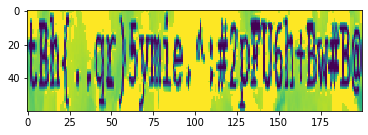

In [7]:
plt.imshow(train_ds[0][0])

In [8]:
net = CNNBiLSTM(num_downsamples=num_downsamples, resnet_layer_id=resnet_layer_id , 
                rnn_hidden_states=lstm_hidden_states, rnn_layers=lstm_layers, max_seq_len=max_seq_len, ctx=ctx)
net.load_parameters('model_checkpoint/handwriting4.params')
#net.load_parameters('models/handwriting_line8.params')
net.hybridize()
ctc_loss = gluon.loss.CTCLoss(weight=0.2)
best_test_loss = 10e5


trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.0001})

In [ ]:
for e in range(epochs):
    train_loss = run_epoch(e, net, train_data, trainer, log_dir, print_name="train", is_train=True)
    test_loss = run_epoch(e, net, test_data, trainer, log_dir, print_name="test", is_train=False)
    test_loss = run_epoch(e, net, test_data, trainer, log_dir, print_name="test", is_train=False)    
    if test_loss < best_test_loss:
        print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
        net.save_parameters(os.path.join(checkpoint_dir, checkpoint_name))
        best_test_loss = test_loss
        
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

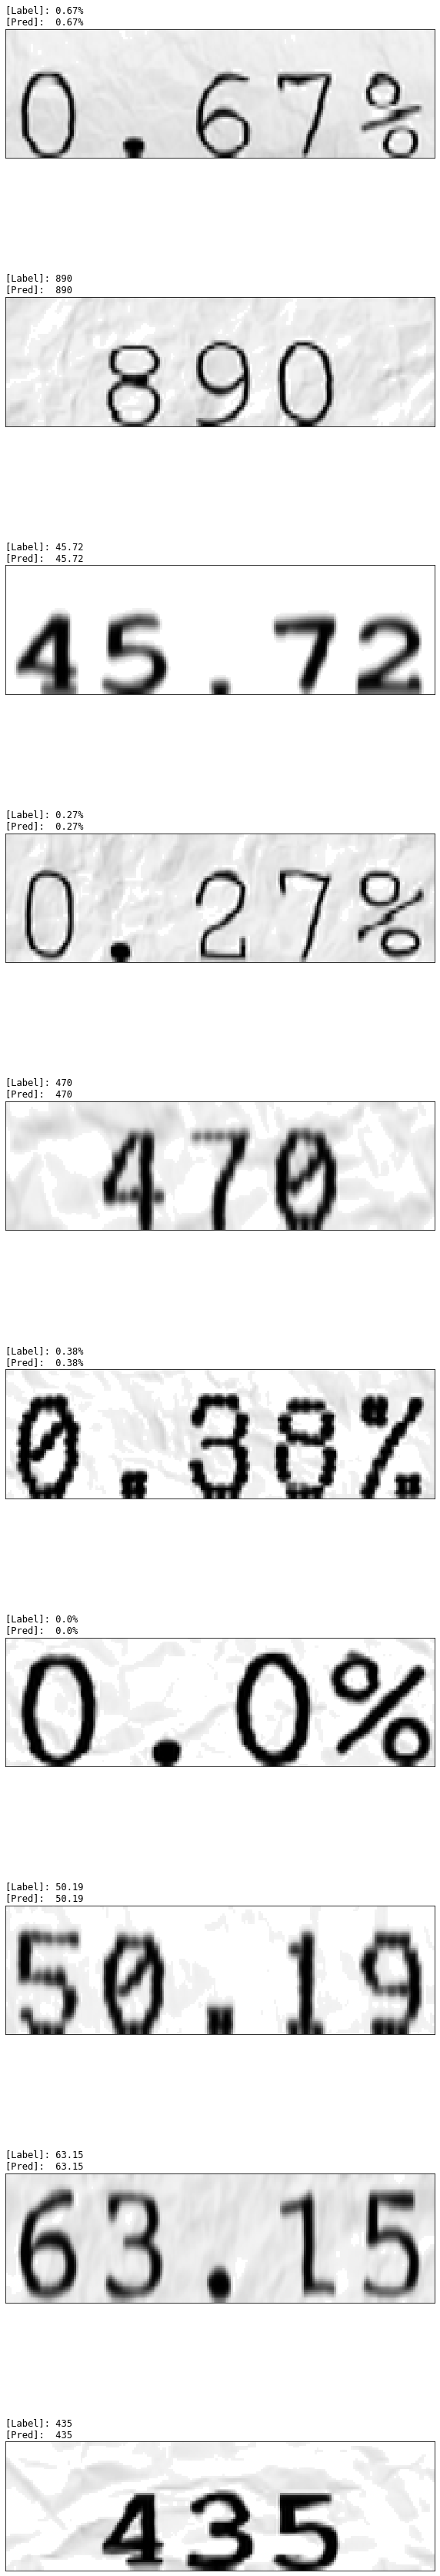

In [9]:


figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, figsize=(10, 6.3*figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, actual_label = test_ds[n]
    #print(image.shape)
    image, _ = transform(image, actual_label)
    plt.figure
    plt.imshow(image[0])
    image = nd.array(image)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    output = net(image)
    predictions = output.softmax().topk(axis=2).asnumpy()
    decoded_prediction_text = decode(predictions)[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')
    axs[i].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    axs[i].set_title("[Label]: {}\n[Pred]:  {}".format(actual_label.replace("&quot", '\"').replace("&amp", "&").replace('";', '\"'), decoded_prediction_text),
                    fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
    axs[i].tick_params(axis='both',       
                       which='both',      
                       bottom=False,      
                       top=False,         
                       left=False,
                       right=False,
                       labelleft=False,
                       labelbottom=False)



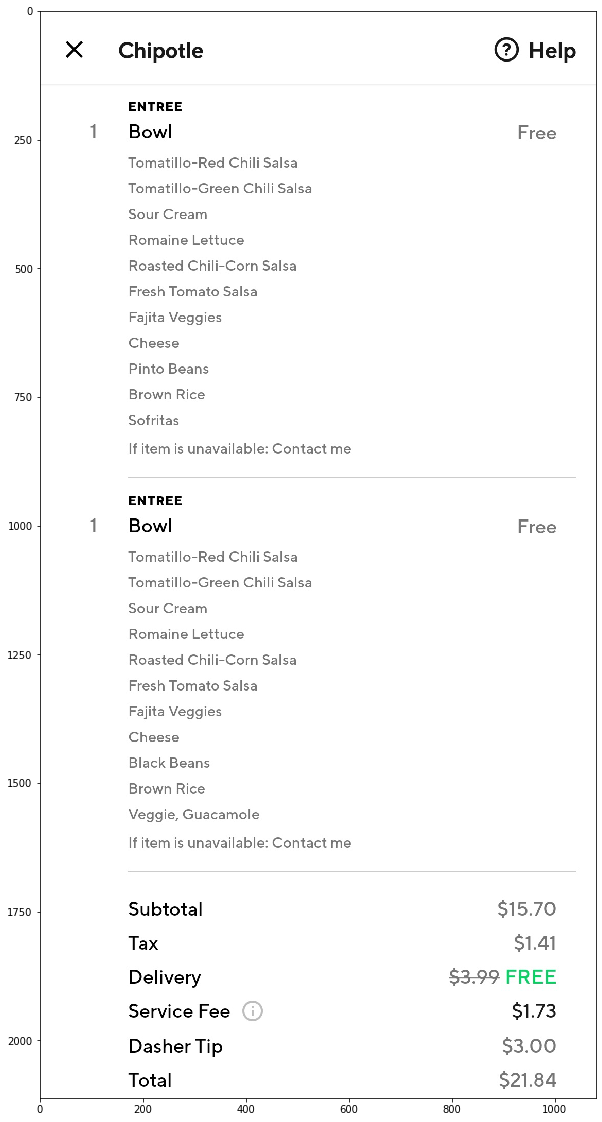

In [10]:
import matplotlib.image as mpimg 
plt.rcParams['figure.figsize'] = [15,20]
warped = mpimg.imread('eg14.jpg')
#print("w:",warped.shape)
plt.figure()
plt.imshow(warped, cmap = 'Greys_r')


gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)

#plt.imshow(gray)#binary


ret,thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY_INV)
ret2,thresh2 = cv2.threshold(gray,150,255,cv2.THRESH_BINARY)
#plt.imshow(thresh2)
#dilation


kernel = np.ones((2,2), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)


hist = cv2.reduce(img_dilation,1, cv2.REDUCE_AVG)
#print(hist)
th = 2
H,W = warped.shape[:2]
uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

#print('u:',uppers)
#print('l:',lowers)

img_lineseg = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for y in uppers:
    cv2.line(img_lineseg, (0,y), (W, y), (255,0,0), 1)

for y in lowers:
    cv2.line(img_lineseg, (0,y), (W, y), (0,255,0), 1)

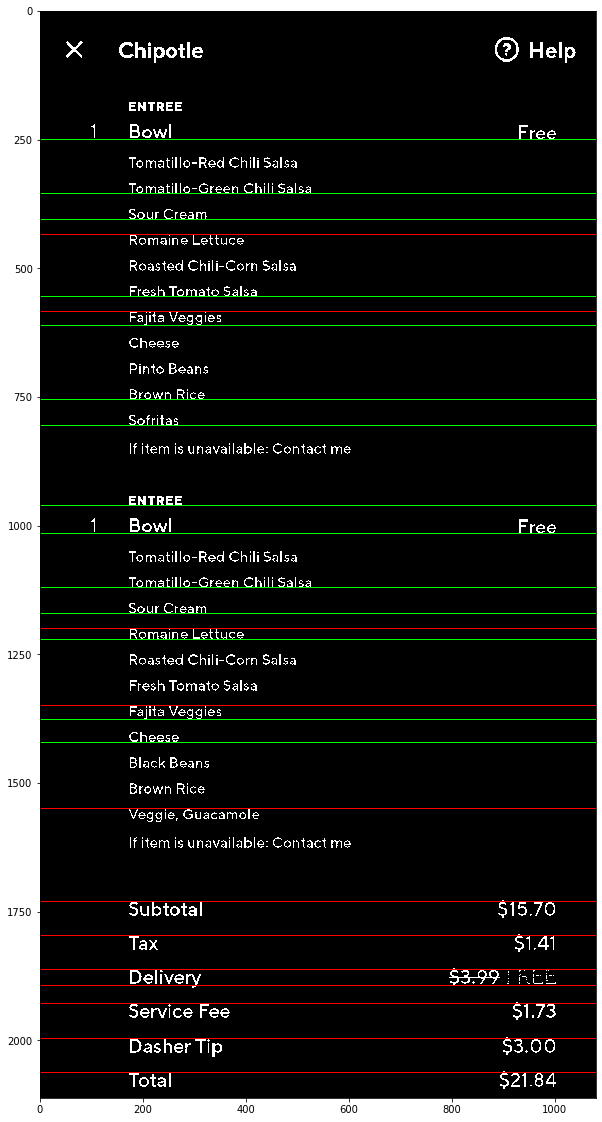

In [11]:
line_images_array = []
img_lines = cv2.cvtColor(thresh2, cv2.COLOR_GRAY2BGR)
plt.figure()
plt.imshow(img_lineseg)

/Users/skundala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


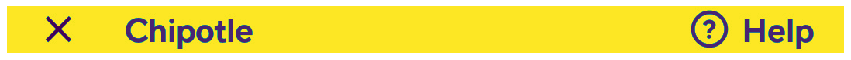

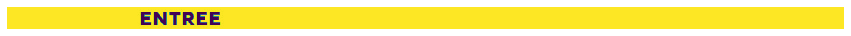

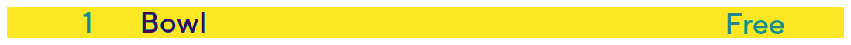

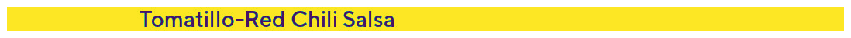

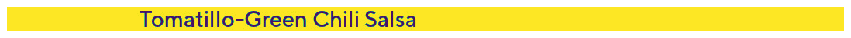

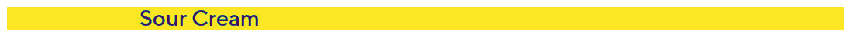

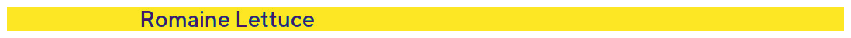

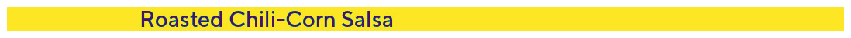

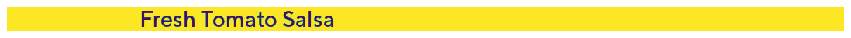

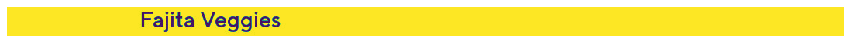

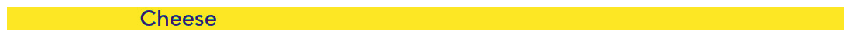

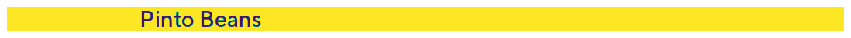

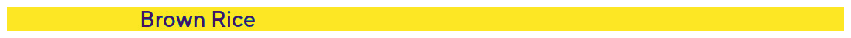

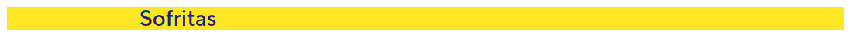

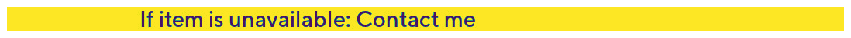

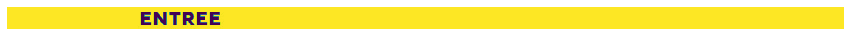

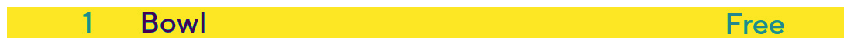

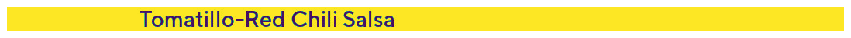

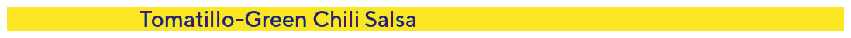

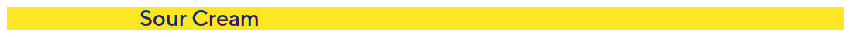

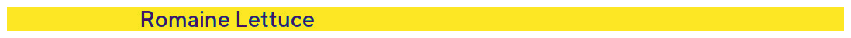

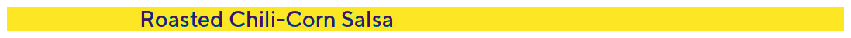

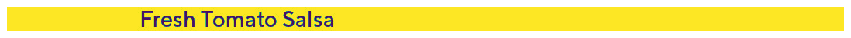

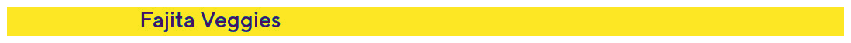

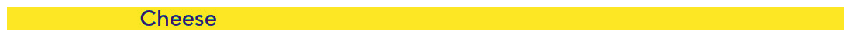

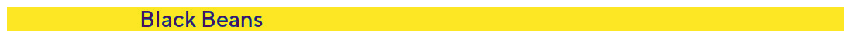

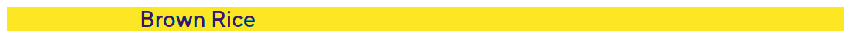

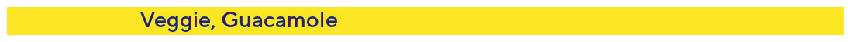

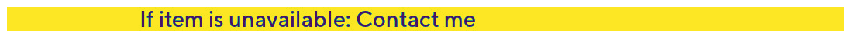

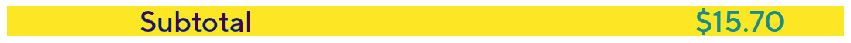

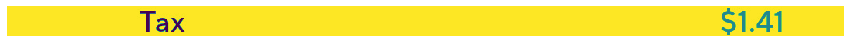

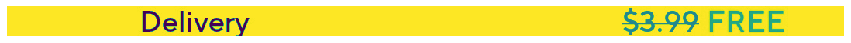

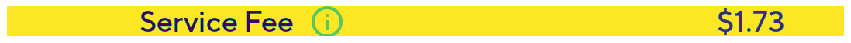

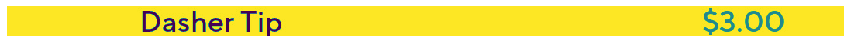

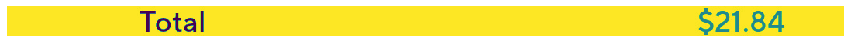

In [12]:
for i in range(len(uppers)):
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    try:
        plt.imshow(gray[uppers[i]-5:lowers[i]+5,:])
        ax.axis('off')
        line_images_array.append(gray[uppers[i]-5:lowers[i]+5,:])
    except:
        plt.imshow(plt.imshow(gray[uppers[i]:lowers[i],:]))
        ax.axis('off')
        line_images_array.append(gray[uppers[i]:lowers[i],:])

In [13]:
def imageResize(image, desired_size):
    size = image.shape[:2]
    ratio_w = float(desired_size[0])/size[0]
    ratio_h = float(desired_size[1])/size[1]
    new_size = (int(ratio_w*size[0]), int(ratio_h*size[1]))
    image = cv2.resize(image, (new_size[1], new_size[0]))
    size = image.shape
    #print(size)
    return image




In [14]:
def erode( img, kern_size = 45 ):
    retval, img = cv2.threshold(img, 254.0, 255.0, cv2.THRESH_BINARY) # threshold to deal with only black and white.
    kern = np.ones((kern_size,kern_size),np.uint8) # make a kernel for erosion based on given kernel size.
    eroded = cv2.erode(img, kern, 1) # erode your image to blobbify black areas
    y,x = eroded.shape # get shape of image to make a white boarder around image of 1px, to avoid problems with find contours.
    return cv2.rectangle(eroded, (0,0), (x,y), (255,255,255), 1)

image_lines = []
for i in range(len(line_images_array)):
    image = line_images_array[i]
    #print(image.shape[1])
    imageW = erode(image)
    #plt.figure()
    #plt.imshow(image)
    #plt.figure()
    #plt.imshow(imageW)

    ret3,thresh3 = cv2.threshold(imageW,150,255,cv2.THRESH_BINARY_INV)
    imageW = np.uint8(thresh3)
    #plt.imshow(imageW)
    contours, _ = cv2.findContours(imageW, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key = cv2.contourArea, reverse = False)[:5]
    screenCnt = []
    for c in contours:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        #print(len(approx))
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        screenCnt.append(approx)
    #print(screenCnt)
    #cv2.drawContours(image,contours, -1,(0,255,0),3)
    #plt.imshow(image)
    word_image = []
    for j in range(len(screenCnt)):
        # get x and y coordinate of the first bounding box
        if len(screenCnt[j])==4:
            #print(i)
            x1,y1 = screenCnt[j][0][0][0], screenCnt[j][0][0][1]
            #print(i,x3)
            y2 = screenCnt[j][1][0][1]
            x3 = screenCnt[j][3][0][0]
            w = x3-x1
            h = y2-y1
            word_image.append(image[y1:y2,x1+22:x3-20])
    #for k in word_image:
     #   plt.figure()
     #   plt.imshow(k)
    image_lines.append(word_image)


In [15]:
decoded_line = []
for word_image in image_lines:
    decoded_text = []
    #print("new line:")
    for i in range(len(word_image)):
        image = word_image[i]
        #print(image.shape)
        if image.shape[0]>0 and image.shape[1]>0:
            image2 = imageResize(image,(60,200))
        else:
            continue
        #plt.figure()
        #print(image2.shape)
        #plt.imshow(image2)
        image, _ = transform(image2, '0')
        
        image = nd.array(image)
        image = image.as_in_context(ctx)
        image = image.expand_dims(axis=0)
        #print(image.shape)
        output = net(image)
        predictions = output.softmax().topk(axis=2).asnumpy()
        decoded_prediction_text = decode(predictions)[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"').replace('|','l').lower().strip()
        
        #print(decoded_prediction_text)
        decoded_text.append(decoded_prediction_text)
    decoded_line.append(' '.join(string for string in decoded_text))

In [16]:
for i in range(0,3):
    x = decoded_line[i].strip()
    if x.isalnum() or x.replace(" ","").replace('&',''):
        print('Store:', x.split(' ')[0].strip())
        break

Store: chpot0e


In [17]:
all_posb_tot = []
tot_found = False
possible_list_total = ['total','tot','amount','amt','due','oal']
for i in range(len(decoded_line)-1,len(decoded_line)-5,-1):
    for j in possible_list_total:
        if decoded_line[i].strip().startswith(j):
            tot_found=True
            all_posb_tot.append(decoded_line[i].strip()+" "+str(i))
print(all_posb_tot)


['oal $21.84 35']


In [ ]:
# get the name of the store
# it is expected that the store name is stored in 1st 2-3 lines.



        
    

In [ ]:
def pos_con(string):
    if ('.' in string[1:] and string[1:].count('.')==1):
        return string.find('.'),'.'
    else if (' ' in string[1:] and string[1:].count(' ')==1):
        return string.find(' '),' '

for i in decoded_line:
    x = i.split()
    for j in range(len(x)):
        pos = 0
        if x[j].startswith('$') and len(x[j])>1:
            pos,con = pos_con(x[j])
        if x[j].startswith('s') and len(x[j])>1:
            pos,con = pos_con(x[j])
        if pos == 0:
            continue
            
            
            